In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Finsearch/

/content/drive/MyDrive/Finsearch


In [3]:
import yfinance as yf

In [4]:
%ls

'DeepRL for Stock trading.ipynb'   nifty50_2010_2019.csv


In [5]:
nifty50 = yf.download('^NSEI', start='2010-01-01', end='2019-06-30')
nifty50.to_csv('nifty50_2010_2019.csv')

[*********************100%%**********************]  1 of 1 completed


In [6]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.8 MB/s eta 0:00:00


In [14]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['Date']
        self.stock_price_history = data['Adj Close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost

        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  # (Action, Amount) where Action: -1: Buy, 0: Hold, 1: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))

        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance

    def reset(self, seed = None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}

    def step(self, action):
        assert self.action_space.contains(action)
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]
        amount = int(self.initial_balance * action[1] / current_price)

        if action[0] > 0:  # Buy
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  # Sell
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)

        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value
        risk_free_rate = 0.02  # Example risk-free rate
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0
        reward = sharpe_ratio

        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()

        self.current_step += 1

        if self.current_step == len(self.data['Adj Close']):
            done = True
        else:
            done = False

        self.done = done

        info = {}
        return obs, reward, done, False,info


    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])

    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]

        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)

    def render_all(self):
      df = self.render_df.set_index('Date')

      fig, ax1 = plt.subplots(figsize=(18, 6))

      # Plotting market value on the left y-axis
      ax1.plot(df.index, df['market_value'], label='Market Value', color='blue', linestyle='--')
      ax1.set_xlabel('Date')
      ax1.set_ylabel('Market Value', color='blue')
      ax1.tick_params(axis='y', labelcolor='blue')

      # Create a second y-axis for the price data
      ax2 = ax1.twinx()
      ax2.plot(df.index, df['price'], label='Price (Right)', color='black')
      ax2.set_ylabel('Price', color='black')
      ax2.tick_params(axis='y', labelcolor='black')

      fig.tight_layout()  # Adjust the plot to make sure both y-labels are visible

      # Adding buy/sell markers as previously implemented
      for idx in df.index.tolist():
          if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
              ax2.plot(
                  idx,
                  df.loc[idx]["price"] - 1,
                  'g^'
              )
              ax2.text(idx, df.loc[idx]["price"] - 3, df.loc[idx]['amount'], c='green', fontsize=8,
                      horizontalalignment='center', verticalalignment='center')
          elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
              ax2.plot(
                  idx,
                  df.loc[idx]["price"] + 1,
                  'rv'
              )
              ax2.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c='red', fontsize=8,
                      horizontalalignment='center', verticalalignment='center')

      plt.title('Market Value and Stock Price Over Time')
      plt.show()

In [8]:
!pip install stable-baselines3

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [13]:
from stable_baselines3 import PPO
# Initialize Environment with Nifty50 data

nifty50_data = yf.download('^NSEI', start='2010-01-01', end='2019-06-30')
print(nifty50_data.head())
nifty50_data.reset_index(inplace=True)  # Reset index to create a 'Date' column
nifty50_data['Date'] = pd.to_datetime(nifty50_data['Date']).dt.date
env = StockTradingEnv(nifty50_data, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)

# Train the PPO Model
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100_000, progress_bar=True)
model.save("ppo_nifty50")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%%**********************]  1 of 1 completed

Output()

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195  5232.200195   
2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902  5277.899902   
2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805  5281.799805   
2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098  5263.100098   
2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000  5244.750000   

            Volume  
Date                
2010-01-04       0  
2010-01-05       0  
2010-01-06       0  
2010-01-07       0  
2010-01-08       0  


[*********************100%%**********************]  1 of 1 completed


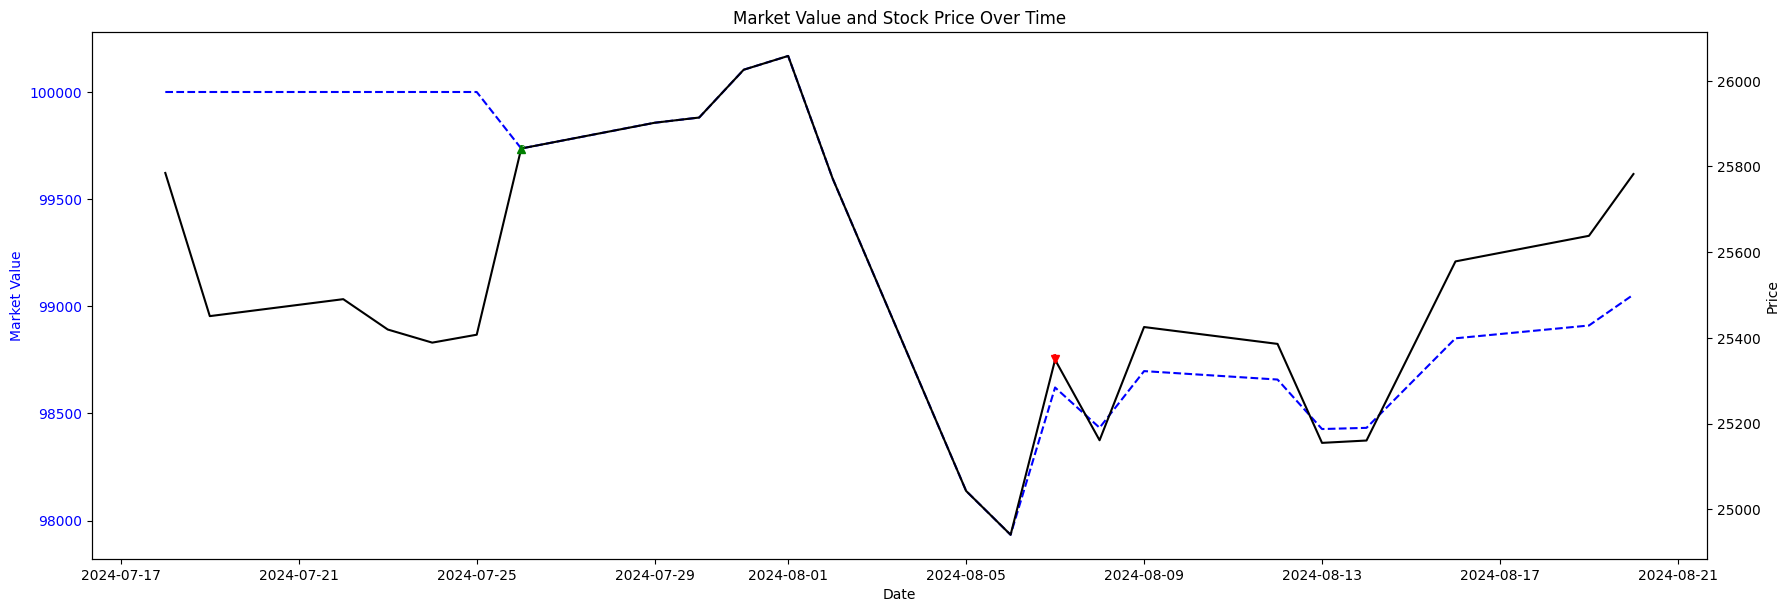

In [15]:
# Fetch Nifty100 data for the past 6 weeks
nifty100_data = yf.download('^CNX100', start='2024-07-17', end='2024-08-21')
nifty100_data.reset_index(inplace=True)  # Reset index to create a 'Date' column
nifty100_data['Date'] = pd.to_datetime(nifty100_data['Date']).dt.date

# Initialize environment with Nifty100 data

env = StockTradingEnv(nifty100_data, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)



# Load the trained model
model = PPO.load("ppo_nifty50", env=env)

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(len(nifty100_data['Adj Close'])):
    action, _state = model.predict(obs)
    obs, reward, done, info = vec_env.step(action)

env.render_all()
